<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/model_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generate tokenized descriptions and reviews

In [2]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (500/500), done.
remote: Compressing objects: 100% (471/471), done.
remote: Total 500 (delta 264), reused 134 (delta 23), pack-reused 0
Receiving objects: 100% (500/500), 3.39 MiB | 6.36 MiB/s, done.
Resolving deltas: 100% (264/264), done.


In [3]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut
device = ut.get_device()

/content/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB


In [4]:
%%capture
!pip install transformers
!pip install requests
!pip install captum

# Sentiment Analysis

In [5]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Explore the dataset

In [8]:
path = "/content/drive/MyDrive/Colab/airbnb/data/reviews/df.pickle"
data = pd.read_pickle(path)
input_ids, attention_masks, labels = data['review_input_ids'], data['review_attention_masks'], data['log_price']

In [10]:
nreviews = np.vectorize(len)(input_ids)

In [11]:
input_ids = np.concatenate(np.array(input_ids))
attention_masks = np.concatenate(np.array(attention_masks))
labels = np.repeat(np.array(labels), nreviews)

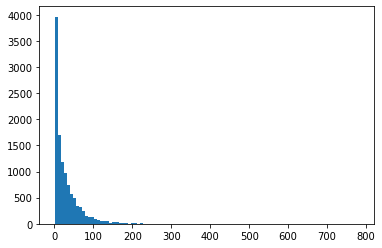

In [13]:
# TODO Visualize the length of the reviews in your dataset
def count_words(string):
    string = string[0]
    return len(string.split())

review_lengths = np.vectorize(count_words)(data["reviews"])

a = plt.hist(review_lengths, bins = 100)
plt.show()

In [14]:
%tensorflow_version 1.x
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

TensorFlow 1.x selected.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Training, Validation, Test Split

Use 15% of the dataset as validation and test set, respectively. Use the other 70% for training.

In [20]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)  
traindf, valdf = data.loc[train_ids], data.loc[val_ids]
ids_train, labels_train, masks_train = traindf['review_input_ids'], traindf['log_price'], traindf['review_attention_masks']
ids_val, labels_val, masks_val = valdf['review_input_ids'], valdf['log_price'], valdf['review_attention_masks']
nreviews_train = np.vectorize(len)(ids_train)
nreviews_val = np.vectorize(len)(ids_val)

In [21]:
ids_train, ids_val =  np.concatenate(np.array(ids_train)), np.concatenate(np.array(ids_val))
labels_train, labels_val = np.repeat(np.array(labels_train), nreviews_train), np.repeat(np.array(labels_val), nreviews_val)
masks_train, masks_val = np.concatenate(np.array(masks_train)), np.concatenate(np.array(masks_val))

In [22]:
# TODO: Print out the shapes of your splitted train, validation, and test set
# Hint: your validation set should contain 500 samples. How many tokens are
# included per sample? 

# (1) print the feature shapes
print(ids_train.shape)
print(ids_val.shape)

# (2) print the label shapes
print(labels_train.shape)
print(labels_val.shape)

# (3) print the attention mask shapes
print(masks_train.shape)
print(masks_val.shape)

(256285, 128)
(54785, 128)
(256285,)
(54785,)
(256285, 128)
(54785, 128)


## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [27]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(torch.from_numpy(ids_train), torch.from_numpy(labels_train), torch.from_numpy(masks_train))
valset = TensorDataset(torch.from_numpy(ids_val), torch.from_numpy(labels_val), torch.from_numpy(masks_val))

b = 256
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)


#regression model


In [28]:
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet

In [29]:
!mkdir -p /content/checkpoints/

In [30]:
import train_utils as train

In [31]:
model1 = LanguageBertNet(fine_tune=False, with_attention_masks=True)
model1 = model1.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
result = train.run_training(model1, optimizer, loss_fn, device, 10, trainloader, valloader, verbose=True)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Saving model...
Finished training after 1905 seconds.


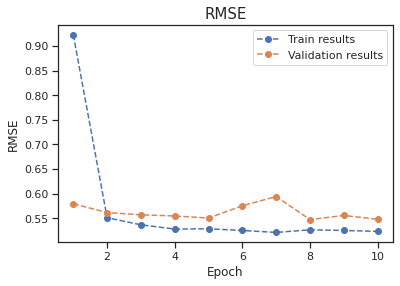

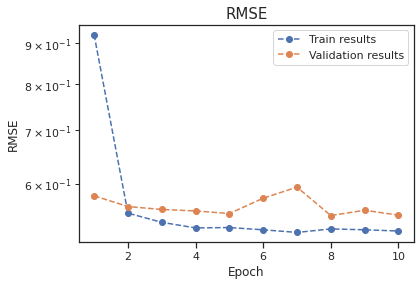

In [34]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear')
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

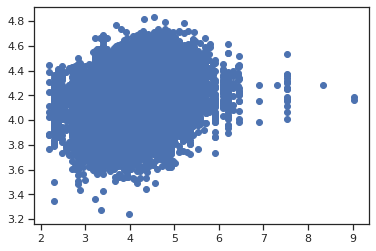

(0.2797969995022064, 0.0)

In [35]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

ys = []
ypreds = []

with torch.no_grad():
    model = model1.eval()

    for ids, labels, masks in valloader:
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model1(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


plt.scatter(ys, ypreds)
plt.show()
pearsonr(ys, ypreds)

## Inference testing

In [36]:
import explainability_utils as explain
text = "This is a luxurious spa appartment, with the best location in the centre of downtown vienna"
attention = explain.pipeline(text, model1, device)
explain.visualize_attention(text, attention)

87.05152893066406


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a luxurious spa appartment, with the best location in the centre of downtown vienna"


## [Optional] Fine-tune BERT model

(This is a non-mandatory, fully optional task)

Can you improve performance by fine-tuning BERT in addition to training the readout classifier?

In [ ]:
b = 32
trainloader = DataLoader(trainset, shuffle=True, num_workers=2, batch_size=b)
valloader = DataLoader(valset, shuffle=False, num_workers=2, batch_size=b)
model2 = LanguageBertNet(fine_tune=True, with_attention_masks=True, cls_dropout_prob=0.5)
model2 = model2.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)
result = train.run_training(model2, optimizer, loss_fn, device, 20, trainloader, valloader, verbose=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Saving model...
Saving model...
Saving model...
Saving model...


Finished training after 2588 seconds.


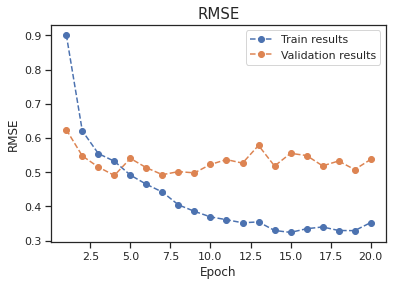

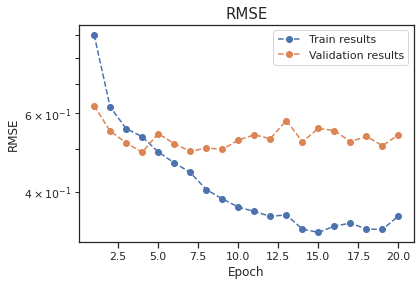

In [ ]:
# plot train and test
train_losses, val_losses, train_rmse, val_rmse = result
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='linear')
ut.plot("RMSE", "RMSE", train_rmse, val_rmse, yscale='log')

In [ ]:
model2.load_state_dict(torch.load("/content/checkpoints/checkpoint.pt"))

<All keys matched successfully>

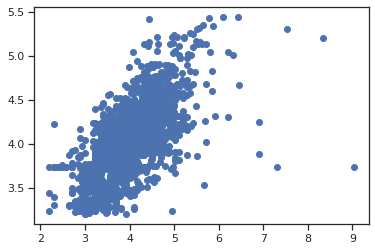

(0.647111194928171, 1.3197105624940958e-203)

In [ ]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt

ys = []
ypreds = []

with torch.no_grad():
    model = model2.eval()

    for ids, labels, masks in valloader:
        ids, masks = ids.to(device), masks.to(device)
        y_pred = model(ids, masks)[0]
        y_pred = list(y_pred.detach().cpu())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)


plt.scatter(ys, ypreds)
plt.show()
pearsonr(ys, ypreds)

In [ ]:
text = "This is a modest appartment, with a backyard location in the centre of downtown vienna"
attention = explain.pipeline(text, model1, device)
explain.visualize_attention(text, attention)

104.84989166259766


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"This is a modest appartment, with a backyard location in the centre of downtown vienna"


In [ ]:
# do you want to save a checkpoint run this chunk
!cp /content/checkpoints/descriptions_20epochs_1e-lr_fine_tuned.pt.pt /content/drive/MyDrive/Colab/airbnb/logs